<a href="https://colab.research.google.com/github/Lawrence-Krukrubo/Advanced-Data-Science/blob/master/cassava_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [22]:
import os
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import json
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
print('All imported!')

All imported!


In [23]:
# set the os Kaggle Environment
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Colab_Notebooks/Kaggle"

In [24]:
%cd /content/gdrive/MyDrive/Colab_Notebooks/Kaggle

/content/gdrive/MyDrive/Colab_Notebooks/Kaggle


In [25]:
%pwd

'/content/gdrive/MyDrive/Colab_Notebooks/Kaggle'

Cell below is to uninstall kaggle, upgrade pip and install kaggl= 1.5.6.<br>No need to run this cell yet.

In [8]:
# !pip uninstall -y kaggle
# !pip install --upgrade pip
# !pip install kaggle==1.5.6
# !kaggle -v

In [26]:
!ls

cassava_classification.ipynb   test_images     train_tfrecords
kaggle.json		       test_tfrecords  val_images
label_num_to_disease_map.json  train.csv
sample_submission.csv	       train_images


Download the Cassava classification data set from Kaggle if not seen above, run cell below...

In [10]:
# !kaggle competitions download -c cassava-leaf-disease-classification

In [11]:
# unzipping the zip files and deleting the zip files (do this for fresh download only)
# !unzip \*.zip  && rm *.zip

Let's see the different labels of cassava leaves as listed in the `label_num_to_disease_map.json file`

In [27]:
# Opening JSON file 
f = open('label_num_to_disease_map.json', 'r')

# returns JSON object as  
# a dictionary 
labels_dict = json.load(f) 
labels_dict

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

let's see the train.csv and sample-submission.csv

In [28]:
train_df = pd.read_csv('train.csv')
print(f'train shape is {train_df.shape}')
train_df.head()

train shape is (21397, 2)


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [29]:
sample_submission_df = pd.read_csv('sample_submission.csv')
print(f'sample shape is {sample_submission_df.shape}')
sample_submission_df.head()

sample shape is (1, 2)


,image_id,label
0,2216849948.jpg,4


In [15]:
train_df.label.unique()

array([0, 3, 1, 2, 4])

Let's see how many healthy cassava leaves are in the data, out of the 21,397 cassava leaves in the training set.

In [30]:
healthy_df = train_df[train_df.label==4]
print(healthy_df.shape)
healthy_df.head()

(2577, 2)


,image_id,label
8,1001723730.jpg,4
17,1003442061.jpg,4
30,100560400.jpg,4
47,1009126931.jpg,4
62,1010806468.jpg,4


so we have 2,577 healthy cassava leaves out of 21,937 images. This is a mere 12% of the total images.

Let's traverse the data using the OS library

In [31]:
# Directory with our training cassava pictures
train_img_dir = os.path.join('/content/gdrive/MyDrive/Colab_Notebooks/Kaggle/train_images')

# Directory with our testing casasava pictures
test_img_dir = os.path.join('/content/gdrive/MyDrive/Colab_Notebooks/Kaggle/test_images')

In [32]:
print('total training cassava images:', len(os.listdir(train_img_dir)))
print('total testing cassava images', len(os.listdir(test_img_dir)))

total training cassava images: 21397
total testing cassava images 1


<h3>Visualizing The Images</h3>

Let's visualize a few of the images, first let's create datafraes for each image class. We created the healthy class df already.

In [33]:
cbb_df = train_df[train_df.label==0]  # Cassava Bacterial Blight leaves 
cbsd_df = train_df[train_df.label==1]  # Cassava Brown Streak Disease leaves
cgm_df = train_df[train_df.label==2]  # Cassava Green Mottle leaves
cmd_df = train_df[train_df.label==3]  # Cassava Mosaic Disease leaves

In [79]:
np.random.randint(1, 5, 1)[0]

2

Next, we create a simple plot function for the different cassava leaves

In [84]:
import matplotlib.image as mpimg
def plot(df, nrows=1, ncols=5):
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4.5, nrows * 8)

    pic_index = np.random.randint(0, len(df)-(ncols+1), 1)[0]
    pic_index += ncols
    _pix = [os.path.join(train_img_dir, fname) 
                    for fname in df.image_id[pic_index-ncols:pic_index]]
    
    for i, img_path in enumerate(_pix):
    # Set up subplot; subplot indices start at 1
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off') # Don't show axes (or gridlines)

        img = mpimg.imread(img_path)
        plt.imshow(img)

    plt.show()

Let's see 5 samples of the **Healthy cassava** leaves (`healthy`).

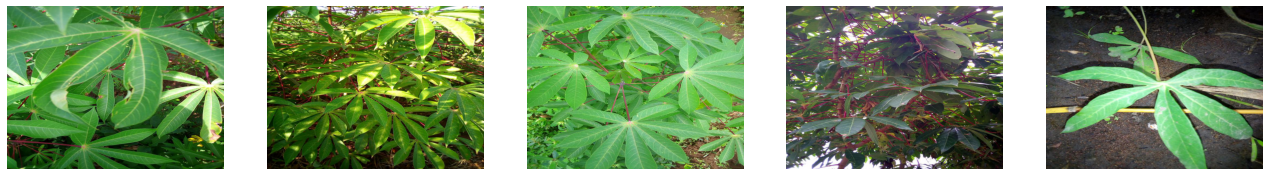

In [86]:
plot(healthy_df)

Let's see 5 samples of **Cassava Bacterial Blight** leaves (`cbb`).

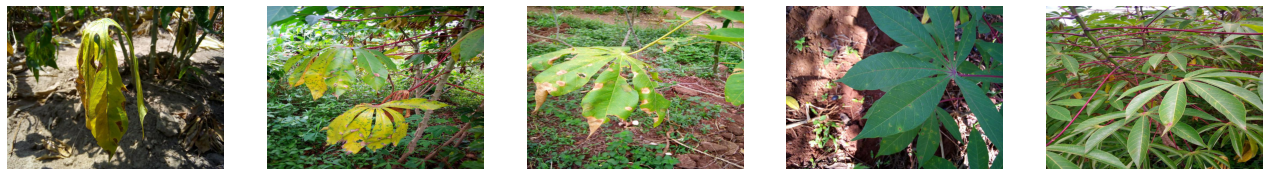

In [90]:
plot(cbb_df)

Let's see 5 samples of **Cassava Brown Streak Disease** leaves (`cbsd`).

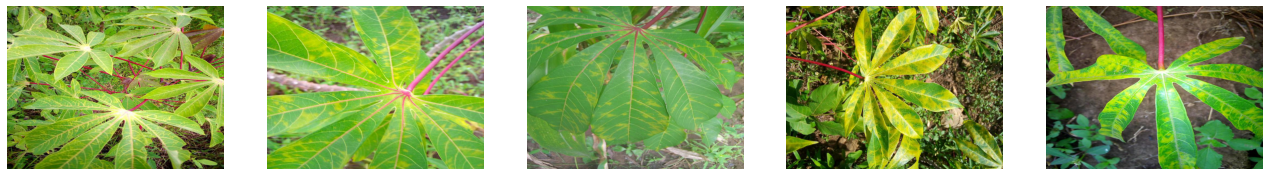

In [93]:
plot(cbsd_df)

Let's see 5 samples of **Cassava Green Mottle** leaves (`CGM`).

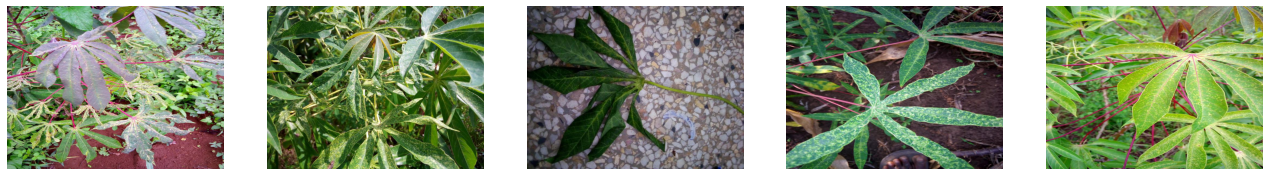

In [96]:
plot(cgm_df)

Let's see 5 samples of the **Cassava Mosaic Disease** leaves (`CMD`).

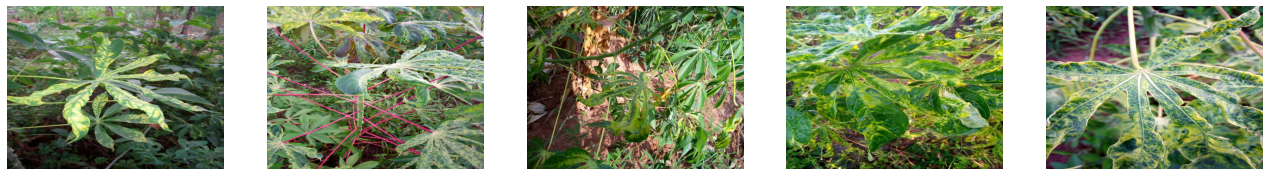

In [99]:
plot(cmd_df)

<h3>Splitting the training dataset to train and val sets</h3>

In [48]:
from sklearn.model_selection import train_test_split
x_train, val_train, y_label, val_label = train_test_split(train_df.image_id.to_frame(),
                                                          train_df.label.to_frame(),
                                                          test_size=0.15,
                                                          stratify=train_df.label.to_frame())
print(f'x-train shape is {x_train.shape}')
print(f'y-label shape is {y_label.shape}')
print(f'val-train shape is {val_train.shape}')
print(f'val-label shape is {val_label.shape}')

x-train shape is (18187, 1)
y-label shape is (18187, 1)
val-train shape is (3210, 1)
val-label shape is (3210, 1)


In [51]:
x_train_names = list(x_train.image_id)
val_train_names = list(val_train.image_id)

In [50]:
from PIL import Image
from numpy import asarray
from skimage.transform import resize
from tqdm import tqdm

def extract_images(img_names, source_dir, H, W):
    images = []
    for img in tqdm(img_names):
        # load the image
        img = Image.open(source_dir+'/'+img)
        # convert image to numpy array
        data = asarray(img)
        # resize the image from the (800, 600, 3) to (224, 224, 3) 
        # This maintains the shape of (H, W, C)
        img_resized = resize(data, (H, W))
        # Now resize to (1, 224, 224, 3) to accommodate (B,H,W,C)
        img_resized = np.expand_dims(img_resized, axis=0)
        images.append(img_resized)
    images = tuple(images)
    array = np.row_stack(images)
    return array

Load the validation data

In [63]:
# val_array = extract_images(val_train_names, 'train_images', 224, 224) 
print(val_array.shape)

(3210, 224, 224, 3)


In [54]:
# save the validation data numpy array as csv file
np.save('val_data_2242243_stratify.csv', val_array)

# to load saved data
# loaded_array = np.load('val_data_2242243_stratify.csv.npy')

In [55]:
%ls

cassava_classification.ipynb   train.csv
kaggle.json                    train_images/
label_num_to_disease_map.json  train_tfrecords/
sample_submission.csv          val_data_2242243_stratify.csv
test_images/                   val_data_2242243_stratify.csv.npy
test_tfrecords/                val_images/


In [62]:
val_array[0].shape

(224, 224, 3)

Load the training data

In [ ]:
x_array = extract_images(x_train_names, 'train_images', 224, 224) 
print(x_array.shape)